Files already downloaded and verified
Files already downloaded and verified
Epoch [1/30], Loss: 1.9787
Epoch [1/30], Loss: 1.6051
Epoch [1/30], Loss: 1.6881
Epoch [1/30], Loss: 1.6248
Epoch [1/30], Loss: 1.5901
Epoch [1/30], Loss: 1.4578
Epoch [1/30], Loss: 1.4431
Epoch [2/30], Loss: 1.4322
Epoch [2/30], Loss: 1.3354
Epoch [2/30], Loss: 1.5540
Epoch [2/30], Loss: 1.6446
Epoch [2/30], Loss: 1.1913
Epoch [2/30], Loss: 1.3578
Epoch [2/30], Loss: 1.6378
Epoch [3/30], Loss: 1.4354
Epoch [3/30], Loss: 1.6243
Epoch [3/30], Loss: 1.4207
Epoch [3/30], Loss: 1.4730
Epoch [3/30], Loss: 1.3748
Epoch [3/30], Loss: 1.4661
Epoch [3/30], Loss: 1.3293
Epoch [4/30], Loss: 1.0720
Epoch [4/30], Loss: 1.4342
Epoch [4/30], Loss: 1.5260
Epoch [4/30], Loss: 1.4805
Epoch [4/30], Loss: 1.3173
Epoch [4/30], Loss: 1.1814
Epoch [4/30], Loss: 1.3191
Epoch [5/30], Loss: 1.2741
Epoch [5/30], Loss: 1.4120
Epoch [5/30], Loss: 1.2804
Epoch [5/30], Loss: 1.3805
Epoch [5/30], Loss: 1.4915
Epoch [5/30], Loss: 1.4463
Epoch 

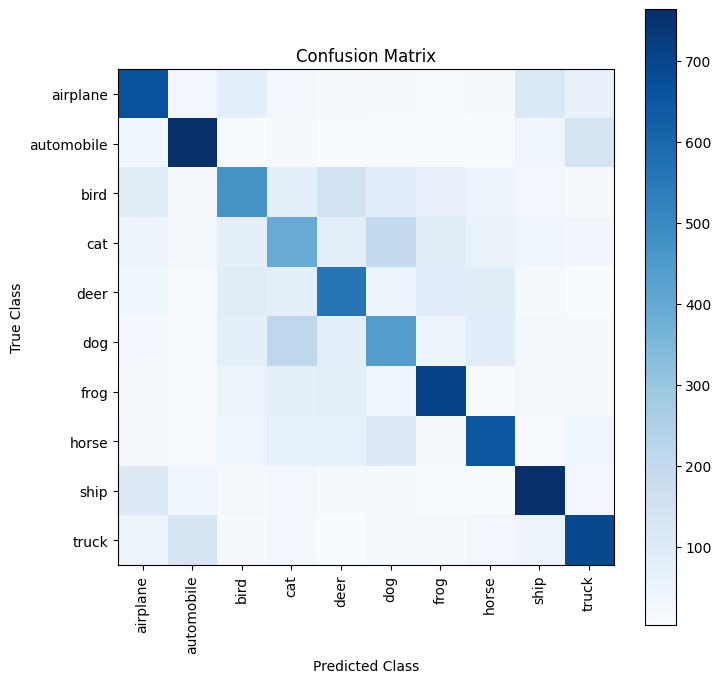

In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Dataset
from collections import deque
import numpy as np
import matplotlib.pyplot as plt


class SampleDataset(Dataset):
    def __init__(self, data, targets, transform=None):
        self.data = data
        self.targets = targets
        self.transform = transform

    def __getitem__(self, index):
        x = self.data[index]
        y = self.targets[index]

        if self.transform:
            x = self.transform(x)

        return x, y

    def __len__(self):
        return len(self.data)


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()

        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
        )
        self.classifier = nn.Sequential(
            nn.Linear(128 * 4 * 4, 256),
            nn.ReLU(inplace=True),
            nn.Linear(256, 10),
        )
        self.memory = deque(maxlen=5000)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

    def memorize(self, dataset):
        self.memory.extend(dataset)

    def train_memory(self, optimizer, criterion):
        if len(self.memory) > 0:
            memory_loader = DataLoader(self.memory, batch_size=128, shuffle=True)
            for x, y in memory_loader:
                x, y = x.to(device), y.to(device)
                optimizer.zero_grad()
                outputs = self(x)
                loss = criterion(outputs, y)
                loss.backward()
                optimizer.step()

    def forget(self, num_samples):
        if len(self.memory) > num_samples:
            for i in range(num_samples):
                self.memory.pop(0)


if __name__ == "__main__":
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])
    train_dataset = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

    train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=2)

    model = CNN()
    criterion = nn.CrossEntropyLoss()

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
    criterion = nn.CrossEntropyLoss()
    
    num_epochs = 30
    
    model.to(device)
    model.float()

    # Training the model
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            model.train()
            images = images.type(torch.FloatTensor).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
                print ('Epoch [{}/{}], Loss: {:.4f}'
                      .format(epoch+1, num_epochs, loss.item()))
        scheduler.step()

    from sklearn.metrics import confusion_matrix, classification_report

    # Set model to evaluation mode
    model.eval()

    true_labels = []
    pred_labels = []

    # Iterating over test dataset
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.type(torch.FloatTensor).to(device)
            labels = labels.to(device)

            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)

            true_labels += labels.cpu().numpy().tolist()
            pred_labels += predicted.cpu().numpy().tolist()

    # Calculating evaluation metrics
    accuracy = (np.array(true_labels) == np.array(pred_labels)).mean()
    print('Overall Accuracy:', accuracy)
    classes = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

    class_report = classification_report(true_labels, pred_labels, target_names=classes)
    print('Classification Report:')
    print(class_report)

    conf_matrix = confusion_matrix(true_labels, pred_labels)
    plt.figure(figsize=(8, 8))
    plt.imshow(conf_matrix, cmap='Blues')
    plt.xticks(ticks=np.arange(len(classes)), labels=classes, rotation=90)
    plt.yticks(ticks=np.arange(len(classes)), labels=classes)
    plt.xlabel('Predicted Class')
    plt.ylabel('True Class')
    plt.title('Confusion Matrix')
    plt.colorbar()
    plt.show()

